In [5]:
import numpy as np
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt


# Final Functions
parameters:
- sample size: N
- seed for randomization
- train-test split ratio

In [30]:
## Note: csv_file is not included in the repo

def get_sample(csv_file, N, seed):
    np.random.seed(seed)
    df = pd.read_csv(csv_file)
    
    #keep only ratings from the most recent 5 years： 2010-2015
    df['datetime'] = df['timestamp'].apply(lambda x: date.fromtimestamp(x))
    df['year'] = df['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
    df = df[df['year']>=date.fromisoformat('2010-01-01').year]
    df.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
    m_counts = df.groupby('movieId').size()
    m_index = m_counts[m_counts>=20].index
    df = df[df['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
    u_counts = df.groupby('userId').size()
    u_index = u_counts[u_counts>=20].index
    df = df[df['userId'].isin(u_index)]
    
    #sample out N users
    users = np.unique(df['userId'])
    u_index_sample = np.random.choice(users, N)
    sample = df[df['userId'].isin(u_index_sample)]
    
#     #plot data
#     users_s, u_count_s = np.unique(sample['userId'], return_counts=True)
#     plt.plot(np.arange(1, len(users_s)+1), sorted(sample.groupby('userId').size(), reverse=True))
#     plt.xlabel('number of users')
#     plt.ylabel('number of rated movies')
#     plt.show()
    
    print('number of unique users:', len(np.unique(sample['userId'])))
    print('number of unique movies:', len(np.unique(sample['movieId'])))
    
    return sample


In [34]:
def get_train_test(sample_data, split, seed):
    np.random.seed(seed)
    sample = pd.read_csv(sample_data)
    sample.drop(['Unnamed: 0'],axis=1,inplace=True) #original index no longer necessary
    
    train, test = train_test_split(sample, test_size=split)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of movies in train:',len(np.unique(train['movieId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    print('number of movies in test:',len(np.unique(test['movieId'])))
    
    return train, test
    

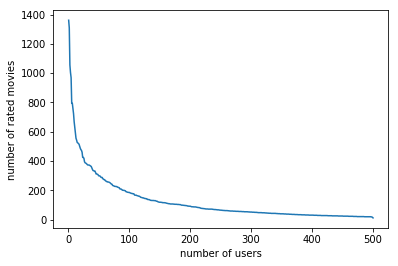

number of unique users: 500
number of unique movies: 3655
number of users in train: 500
number of users in test: 251


In [33]:
small_sample = get_sample('ratings.csv', 500, 10)
train, test = get_train_test(small_sample, 10, 0.3)

# Item-based Collaborative Filtering

- create matrix 
- train model 
- make prediction
- evaluation 

### Prediction & Evaluation

### prediction1

In [14]:
# calculate adjusted ratings based on training data
rating_mean= train.groupby(['movieId'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['movieId','rating_mean']]
adjusted_ratings = pd.merge(train,rating_mean,on = 'movieId', how = 'left', sort = False)
adjusted_ratings['rating_adjusted']=adjusted_ratings['rating']-adjusted_ratings['rating_mean']
# replace 0 adjusted rating values to 1*e-8 in order to avoid 0 denominator
adjusted_ratings.loc[adjusted_ratings['rating_adjusted'] == 0, 'rating_adjusted'] = 1e-8

In [13]:
train.head()

,userId,movieId,rating
348931,2355,6,4.0
348932,2355,16,3.0
348933,2355,21,4.0
348934,2355,25,4.0
348935,2355,32,5.0


In [14]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train.as_matrix(columns = ['userId', 'movieId', 'rating'])
test_data_matrix = test.as_matrix(columns = ['userId', 'movieId', 'rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(47287, 3)
(16284, 3)


/Users/estelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/estelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
train_data_matrix

array([[2.3550e+03, 6.0000e+00, 4.0000e+00],
       [2.3550e+03, 1.6000e+01, 3.0000e+00],
       [2.3550e+03, 2.1000e+01, 4.0000e+00],
       ...,
       [7.4776e+04, 2.3400e+02, 2.0000e+00],
       [9.8827e+04, 3.2130e+03, 4.0000e+00],
       [5.1596e+04, 2.6000e+02, 2.5000e+00]])

In [16]:
test_data_matrix

array([[5.82700e+04, 4.51860e+04, 4.50000e+00],
       [6.86950e+04, 2.99500e+03, 2.00000e+00],
       [1.20046e+05, 1.61000e+02, 4.00000e+00],
       ...,
       [6.99880e+04, 2.29100e+03, 4.00000e+00],
       [7.43560e+04, 1.95700e+03, 4.00000e+00],
       [3.50800e+03, 2.40600e+03, 2.00000e+00]])

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0


[[ 1.00000000e+00 -3.13134289e-04 -3.55561203e-02]
 [-3.13134289e-04  1.00000000e+00  2.98671925e-02]
 [-3.55561203e-02  2.98671925e-02  1.00000000e+00]]


In [29]:
def predict(ratings, similarity):
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [37]:
# Predict ratings on the training data with both similarity score

item_predic_train = predict(train_data_matrix, item_correlation)
item_predic_test  = predict(test_data_matrix, item_correlation)

print('Item-based CF RMSE for test data: ' + str(rmse(item_predic_test, test_data_matrix)))
print('Item-based CF RMSE for train data: ' + str(rmse(item_predic_train, train_data_matrix)))

Item-based CF RMSE for test data: 2187.5797675702765
Item-based CF RMSE for train data: 2172.947798111302


In [38]:
item_predic_train

array([[ 2.27331382e+03,  5.22436449e+00, -7.46702829e+01],
       [ 2.27334513e+03,  1.49024107e+01, -7.53285453e+01],
       [ 2.27330929e+03,  1.97849221e+01, -7.42497854e+01],
       ...,
       [ 7.21865769e+04,  2.04473721e+02, -2.48704482e+03],
       [ 9.54037889e+04,  3.08894789e+03, -3.20430515e+03],
       [ 4.98092104e+04,  2.36772325e+02, -1.71226600e+03]])

### Prediction2

In [132]:
#build matrix
from scipy.sparse import csr_matrix
df_movie_train = train.pivot(index='movieId',columns='userId',values='rating').fillna(0)
df_movie_test = test.pivot(index='movieId',columns='userId',values='rating').fillna(0)
mat_movie_features = csr_matrix(df_movie_train.values)
df_movie_train.head(5)


userId,504,645,1367,1722,1869,2208,2355,2357,2534,2610,...,136264,136971,137135,137169,137189,137236,137375,137498,137677,137972
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,5.0,0.0,0.0,3.5,0.0,4.0,5.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.5,2.0,0.0,0.0,0.0,0.0


In [133]:
df_movie_train.shape

(3594, 500)

In [143]:
def similarity(ratings):
    item_correlation1 = 1 - pairwise_distances(ratings, metric='correlation')
    item_correlation1[np.isnan(item_correlation1)] = 0
    return item_correlation1

In [144]:
item_correlation1 = similarity(df_movie_train)
item_correlation1.shape

(3594, 3594)

In [147]:
sum_=np.array([np.abs(item_correlation1).sum(axis=1)])
sum_ = sum_.T
np.shape(sum_)

(3594, 1)

In [148]:
rate_ = np.array(item_correlation1).dot(np.array(df_movie_train))
rate_/sum_

array([[ 0.13582468,  0.05062787,  0.21346121, ...,  0.07319643,
         0.0723205 ,  0.06595604],
       [ 0.14194429,  0.05158603,  0.23176742, ...,  0.05713722,
         0.10985621,  0.15716071],
       [ 0.00631832, -0.01547731,  0.11298845, ...,  0.0123698 ,
        -0.00679398,  0.01528196],
       ...,
       [ 0.0558674 ,  0.04130579, -0.01217525, ...,  0.01106135,
         0.09686541, -0.00364792],
       [ 0.05441652,  0.03587528, -0.00757077, ...,  0.00842176,
         0.0703173 , -0.00942184],
       [-0.07491952,  0.06135464, -0.13400533, ..., -0.03881219,
        -0.11261116, -0.09121438]])

In [154]:
def predict(ratings, similarity):
    sum_=np.array([np.abs(similarity).sum(axis=1)])
    sum_ = sum_.T
    rate_ = np.array(similarity).dot(np.array(ratings))
    pred = similarity.dot(ratings) / sum_
    return pred

# Function to calculate RMSE
def rmse1(pred, actual):
    # Ignore nonzero terms.
    return sqrt(mean_squared_error(pred, actual))

In [155]:
item_predic_train_1 = predict(df_movie_train, item_correlation1)
np.shape(item_predic_train_1)

(3594, 500)

In [156]:
item_predic_train_1 = pd.DataFrame(item_predic_train_1, index=df_movie_train.index, columns=df_movie_train.columns)
item_predic_train_1.head()

userId,504,645,1367,1722,1869,2208,2355,2357,2534,2610,...,136264,136971,137135,137169,137189,137236,137375,137498,137677,137972
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.135825,0.050628,0.213461,0.126716,0.100590,0.063282,0.073187,0.081996,0.045764,0.039148,...,0.037538,0.135130,0.088490,0.058500,0.169108,0.106720,0.487189,0.073196,0.072321,0.065956
2,0.141944,0.051586,0.231767,0.128544,0.199214,0.061416,0.060447,0.074795,0.033514,0.041914,...,0.046476,0.027480,0.101675,0.054957,0.134925,0.035896,0.465304,0.057137,0.109856,0.157161
3,0.006318,-0.015477,0.112988,0.057095,0.101443,-0.017929,0.082527,-0.007231,-0.002165,0.005509,...,0.020242,0.256361,0.007526,-0.019151,0.006023,0.190280,-0.007833,0.012370,-0.006794,0.015282
4,0.044465,-0.014154,0.189699,0.033098,0.259107,-0.032912,0.038125,0.031307,-0.006500,0.009514,...,0.016579,0.042001,0.014858,-0.013015,-0.004295,0.088403,0.020823,0.029027,0.069188,0.124129
5,-0.020085,-0.023251,0.248522,0.046486,0.212582,-0.062935,0.083515,-0.002403,-0.005488,0.004876,...,0.008037,0.233029,-0.008840,-0.038599,-0.020077,0.235593,-0.102660,0.018474,-0.019269,0.061873


In [157]:
print('Item-based CF RMSE for train data: ' + str(rmse1(item_predic_train_1, df_movie_train)))

Item-based CF RMSE for train data: 0.5404254767284249


In [160]:
item_correlation_test = similarity(df_movie_test)
item_predic_test_1 = predict(df_movie_test, item_correlation_test)
print('Item-based CF RMSE for test data: ' + str(rmse1(item_predic_test_1, df_movie_test)))

Item-based CF RMSE for test data: 0.46860039500530337


### not related

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_movie_features)
cosine_sim = pd.DataFrame(cosine_sim, index=df_movie_features.index, columns=df_movie_features.index)
cosine_sim.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,109487,110102,111362,111759,112183,112290,112556,112623,112852,116797
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.331319,0.285415,0.108333,0.265780,0.327709,0.257889,0.000000,0.230687,0.269328,...,0.082015,0.065325,0.058937,0.000000,0.018528,0.087885,0.036475,0.005872,0.070410,0.0
2,0.331319,1.000000,0.118280,0.020785,0.144886,0.163144,0.082842,0.000000,0.040698,0.235612,...,0.041273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.285415,0.118280,1.000000,0.084307,0.494264,0.434314,0.386659,0.000000,0.419051,0.081877,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.108333,0.020785,0.084307,1.000000,0.190655,0.000000,0.117598,0.000000,0.112967,0.057857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.265780,0.144886,0.494264,0.190655,1.000000,0.331738,0.402504,0.121519,0.417068,0.098588,...,0.026620,0.028741,0.021609,0.032333,0.000000,0.000000,0.023775,0.025835,0.022127,0.0


In [44]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)

    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data, n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse

# method 3

In [ ]:
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[item_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print '{0} most similar items for item {1}:\n'.format(k,item_id)
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;

        else:
            print '{0}: Item {1} :, with similarity of {2}'.format(i,indices.flatten()[i]+1, similarities.flatten()[i])
    return similarities,indices

In [ ]:
similarities,indices=findksimilaritems(3,M)

In [ ]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;
        else:
            product = ratings.iloc[user_id-1,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    print '\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction)      

    return prediction

In [ ]:
prediction = predict_itembased(1,3,M)

# 4